# The Analyzer

In [105]:
# Libraries
import folium
import pandas as pd
import matplotlib.pyplot as plt
import mysql.connector as sql
import seaborn as sns
import scipy.stats as stats
from sklearn import linear_model
from sklearn.model_selection import train_test_split


# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Import data

In [106]:
# Connect to Wine Database
db_connection = sql.connect(host='lx26.hoststar.hosting',
                            database="ch309974_DA_winery", user='ch309974_DA_winery_user', password='ch309974_DA_winery_user1!')

# We assume that all values that are 0 or null don't have Ratings. That's why we exclude it.
query = 'SELECT * FROM wine where bewertung > 0'
df_response = pd.read_sql(sql=query, con=db_connection)

# Remove some 'extreme' values
df = df_response.loc[(df_response['preis_chf'] >= 5) &
            (df_response['preis_chf'] <= 500)]

# Reset index
df = df.reset_index(drop=True)

## Compare wine type to price

In [107]:
# Read the data to a pandas data frame
df_price = df[['typ', 'preis_cl']]

# Show categories of 'Make'
print(df_price['typ'].value_counts())

# Drop extreme values
df_price = df_price.drop(df_price[df_price.preis_cl > 1].index)
df_price.head()

rot           775
weiss         245
rose           93
schaumwein     90
champagner     58
dessert        28
Name: typ, dtype: int64


,typ,preis_cl
0,rot,0.27
1,rot,0.17
2,rot,0.44
3,rot,0.44
4,rot,0.29


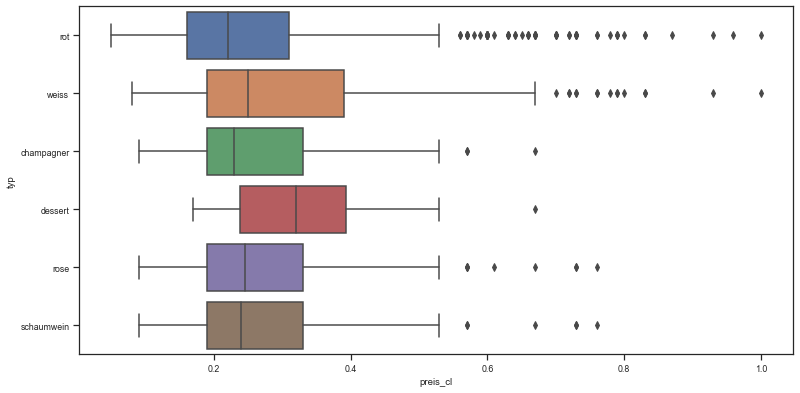

In [108]:
# Plot boxplot with groups
plt.figure(figsize=(12.8,6.4))
ax = sns.boxplot(x="preis_cl",
                 y="typ",
                 data=df_price,
                 orient='h')
plt.show()

## Categorical variable

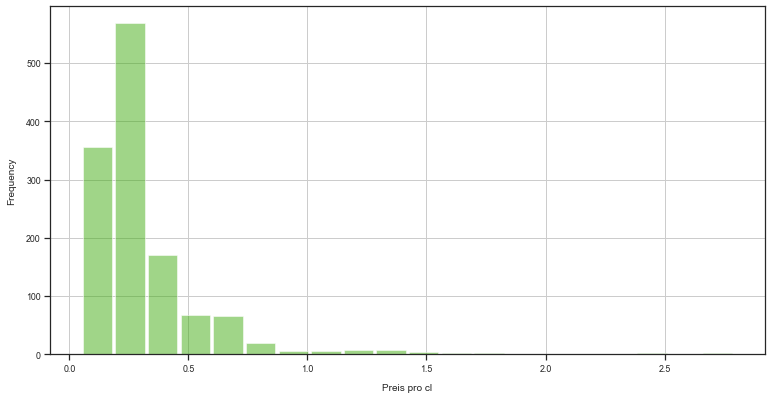

In [109]:
# Plot Histogram
fig = plt.figure( figsize=(12.8,6.4))

n, bins, patches = plt.hist(x=df['preis_cl'], 
                            bins=20, 
                            color='#42AD12',
                            alpha=0.5, 
                            rwidth=0.9
                   )


# Set labels
plt.xlabel('Preis pro cl', fontsize=10, labelpad=10)
plt.ylabel('Frequency', fontsize=10, labelpad=10)

# Plot
plt.grid()
plt.show()

## Scatterplot-Matrix

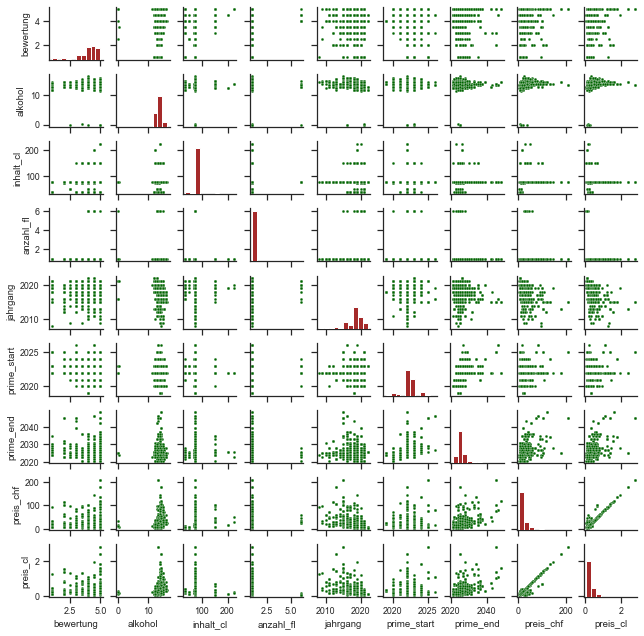

In [110]:
sns.set(style="ticks", font_scale=0.8)
g = sns.PairGrid(df[['bewertung',
                     'alkohol',
                     'inhalt_cl',
                     'anzahl_fl',
                     'jahrgang',
                     'prime_start',
                     'prime_end',
                     'preis_chf',
                     'preis_cl']], 
                 height=1, 
                 aspect=1)
g.map_upper(sns.scatterplot,color='darkgreen', s=8)
g.map_lower(sns.scatterplot, color='darkgreen', s=8)
g.map_diag(plt.hist, color='brown')

## Scatterplot Prime-End versus Price

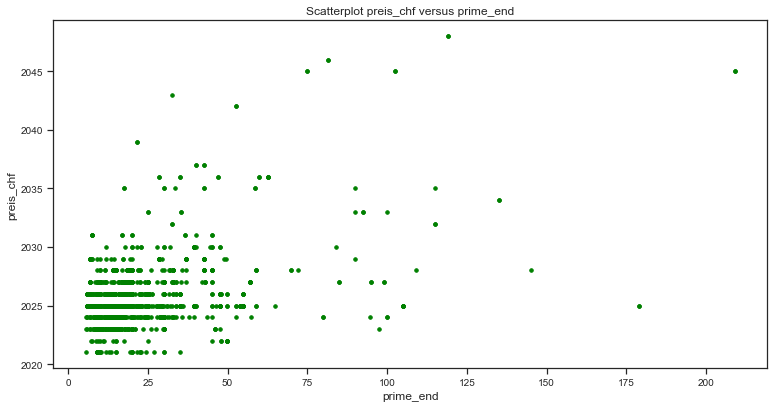

In [111]:
# Scatterplot
plt.figure(figsize=(12.8,6.4))
plt.plot(df['preis_chf'], 
         df['prime_end'], 
         'o', 
         markersize=3.5,
         color="green")

# Add title and axes labels
plt.title('Scatterplot preis_chf versus prime_end', fontsize=12)
plt.ylabel('preis_chf', fontsize=12)
plt.xlabel('prime_end', fontsize=12)

# Set fontsize of tick labels
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

plt.show()

## Linear regression

In [112]:
# Create train and test samples
X_train, X_test, y_train, y_test = train_test_split(df['prime_end'], 
                                                    df['preis_chf'], 
                                                    test_size=0.20, 
                                                    random_state=42)
# Show X_train
print('X_train:')
print(X_train.head(), '\n')

# Show y_train
print('y_train:')
print(y_train.head())

X_train:
634     2030
673     2028
823     2026
1151    2025
135     2026
Name: prime_end, dtype: int64 

y_train:
634     45.00
673     19.95
823      9.95
1151    24.95
135     16.50
Name: preis_chf, dtype: float64


### Fit the simple linear regression model

In [113]:
# Fit the regression model
slope, intercept, r, p, std_err = stats.linregress(X_train, y_train)

# Print results of the regression model
print('Linear regression result:')
print(f'Intercept with y-axis (alpha):            {intercept:.2f}')
print(f'Slope of regression line (beta):          {slope:.3f}')
print(f'p-value:                                  {p:.4f}')
print(f'R-squared (coefficient of determination): {r**2:.4f}')

Linear regression result:
Intercept with y-axis (alpha):            -6269.38
Slope of regression line (beta):          3.106
p-value:                                  0.0000
R-squared (coefficient of determination): 0.2547


### Plot regression line

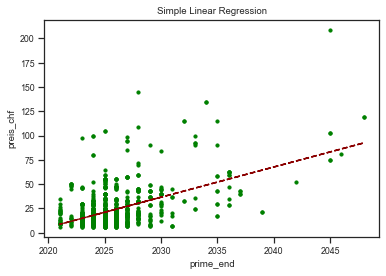

In [114]:
# Function to calculate model predictions
def myfunc(x):
    return slope * x + intercept

# Apply myfunc() to x, i.e. make predictions 
mymodel = pd.Series(map(myfunc, X_train))

# Scatterplot with regression line
plt.figure(figsize=(6,4))
plt.scatter(X_train, y_train, s=10, color='green')
plt.plot(X_train, mymodel, color='darkred', linestyle='dashed')
plt.title('Simple Linear Regression')
plt.xlabel('prime_end')
plt.ylabel('preis_chf')

plt.show()

## ANOVA

In [115]:
# Create subsets (groups)
red = df.loc[df['typ'] == 'rot']
white = df.loc[df['typ'] == 'weiss']
champagne = df.loc[df['typ'] == 'champagner']

# Create ANOVA
fvalue, pvalue = stats.f_oneway(red['preis_cl'],
                                white['preis_cl'], 
                                champagne['preis_cl'])

# Print results
print('F-value:', fvalue.round(3), 'p-value', pvalue.round(4))

F-value: 6.779 p-value 0.0012


### Interpretation of result
Because the p-value is lower than 0.05, the null hypothesis can be rejected, i.e. there is evidence that the prices of red wine, white wine and champagne differ.

## Adding geolocations for all production countries / regions

### Preparing data from csv to plot to map

In [116]:
# Read the data to a pandas data frame
df1 = df[['land', 'lat', 'lon']]

# Preparing data, so it doesn't plot duplicate values more than once
df2 = df1.drop_duplicates()
df3 = df2.reset_index(drop=True)
df3.head()

,land,lat,lon
0,USA,39.7837304,-100.445882
1,Italien,42.6384261,12.674297
2,Argentinien,-34.9964963,-64.9672817
3,Portugal,39.6621648,-8.1353519
4,Schweiz,46.7985624,8.2319736


### Plotting the map

In [117]:
# Initalises the map
m = folium.Map(location=[47.44, 8.65], zoom_start=10)

# Add lat/lon of addresses
for i in range(0, len(df3)):
    folium.Marker(location=(df3.iloc[i]['lat'], 
                            df3.iloc[i]['lon']), 
                  popup=df3.iloc[i]['land']).add_to(m)

# Layer control
folium.LayerControl().add_to(m)

# Plot map
m